In [ ]:
!pip install pyspark
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, StringType, IntegerType, DoubleType, ArrayType
from pyspark import AccumulatorParam
from pyspark import Broadcast
from pyspark.ml.pipeline import Pipeline
import pyspark.sql.functions as F
from sklearn.decomposition import PCA
import pip
pip.main(['install','seaborn','sklearn'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [ ]:
spark = SparkSession.builder.appName('BreastCancer').getOrCreate()
sc = spark.sparkContext

In [ ]:
df = spark.read\
          .option("header", "true")\
          .option("inferSchema", "true")\
          .csv("Breast_Cancer.csv")
data = df

In [ ]:
import pandas as pd
import numpy as np
df = df.toPandas()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [ ]:
#Trying to standardize the data
scaler = StandardScaler()

# Adopt on training set only
scaler.fit(X_train)

#Transforming both trainig and test data
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
#  Feature Extraction:  Principal Component Analysis: PC1, PC2
pca = PCA(n_components=2, random_state=42) 
# Only fit to the training set
pca.fit((X_train))
# transform with PCA model from training
components_train = pca.transform(X_train)
components_test = pca.transform(X_test)

# Using the Pandas Dataframe 
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.columns = (df.drop(['_c0','diagnosis'], axis= 1)).columns
X_test.columns = (df.drop(['_c0','diagnosis'], axis= 1)).columns
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

X_train['PC1'] = components_train[:,0]
X_train['PC2'] = components_train[:,1]
X_test['PC1'] = components_test[:,0]
X_test['PC2'] = components_test[:,1]

In [ ]:
print('X_train - length:',len(X_train), 'y_train - length:',len(y_train))
print('X_test - length:',len(X_test),'y_test - length:',len(y_test))
print('Percent heldout for testing:', round(100*(len(X_test)/len(df)),0),'%')

X_train - length: 455 y_train - length: 455
X_test - length: 114 y_test - length: 114
Percent heldout for testing: 20.0 %


In [ ]:
#Checking whether the data types are correct #
for col in data.columns:
    if col not in ['_c0','diagnosis']:
        data = data.withColumn(col,data[col].cast(FloatType()))

In [ ]:
data = data.withColumn('diagnosis',F.when(data.diagnosis=='M',1).otherwise(0))
data.toPandas().head(5)

,_c0,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,1,17.990000,10.380000,122.800003,1001.000000,0.11840,0.27760,0.3001,0.14710,...,25.379999,17.330000,184.600006,2019.000000,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,1,20.570000,17.770000,132.899994,1326.000000,0.08474,0.07864,0.0869,0.07017,...,24.990000,23.410000,158.800003,1956.000000,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,2,1,19.690001,21.250000,130.000000,1203.000000,0.10960,0.15990,0.1974,0.12790,...,23.570000,25.530001,152.500000,1709.000000,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,3,1,11.420000,20.379999,77.580002,386.100006,0.14250,0.28390,0.2414,0.10520,...,14.910000,26.500000,98.870003,567.700012,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,4,1,20.290001,14.340000,135.100006,1297.000000,0.10030,0.13280,0.1980,0.10430,...,22.540001,16.670000,152.199997,1575.000000,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
class DictAccumulatorParam(AccumulatorParam):
    def zero(self,initialValue):
        return initialValue

    def addInPlace(self, v1, v2):
        v1.update(v2)
        return v1
    
def test_zero_variance(d,acc):
    global df_pd
    col = d[0]
    value = d[1]
    try:
        mean = df_pd.value['mean'][col]
        std = df_pd.value['stddev'][col]
        if float(value)==float(mean) and float(std)==0.0:
            acc.add({col:True})
            return True
        else:
            acc.add({col:False})
            return False
    except KeyError:
        acc.add({col:False})
        return False

In [ ]:
df_pd = data.toPandas()
df_pd.index = df_pd["diagnosis"]
del df_pd["diagnosis"]
df_pd = df_pd.transpose()

df_pd = sc.broadcast(df_pd)

In [ ]:
acc = sc.accumulator({}, DictAccumulatorParam())  
values = data.first().asDict()
input_value = sc.parallelize(values.items())
dummy = input_value.map(lambda x:test_zero_variance(x,acc))\
                  .map(lambda x:(x,1))\
                  .reduceByKey(lambda x,y:x+y)
dummy_collect = dummy.collect()

In [ ]:
acc.value

{'_c0': False,
 'area_mean': False,
 'area_se': False,
 'area_worst': False,
 'compactness_mean': False,
 'compactness_se': False,
 'compactness_worst': False,
 'concave points_mean': False,
 'concave points_se': False,
 'concave points_worst': False,
 'concavity_mean': False,
 'concavity_se': False,
 'concavity_worst': False,
 'diagnosis': False,
 'fractal_dimension_mean': False,
 'fractal_dimension_se': False,
 'fractal_dimension_worst': False,
 'perimeter_mean': False,
 'perimeter_se': False,
 'perimeter_worst': False,
 'radius_mean': False,
 'radius_se': False,
 'radius_worst': False,
 'smoothness_mean': False,
 'smoothness_se': False,
 'smoothness_worst': False,
 'symmetry_mean': False,
 'symmetry_se': False,
 'symmetry_worst': False,
 'texture_mean': False,
 'texture_se': False,
 'texture_worst': False}

**Using Principal Component Analysis to reduce the number of Data Visualized**

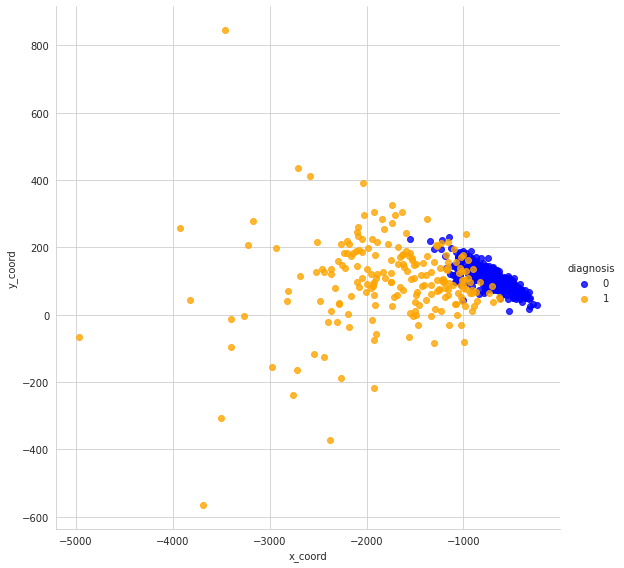

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import UserDefinedFunction
from pyspark.ml.feature import VectorAssembler

import regex

def g(point,co_ord):
    if co_ord=='x':
        value = regex.split('\s+',point)[0][1:]
    else:
        
        value =  regex.split('\s+',point)[1][:-1]
    return value

feature_columns = list(filter(lambda x:x not in ['_c0','label','dummy'],data.columns))
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df = assembler.transform(data)

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)

pca_result = model.transform(df)
result = pca_result.select("pcaFeatures")

get_x = UserDefinedFunction(lambda point:g(point,'x'), StringType())
get_y = UserDefinedFunction(lambda point:g(point,'y'), StringType())
convert_to_string = UserDefinedFunction(lambda point:str(point.toArray()),StringType())

pca_result = pca_result.withColumn('pcaFeatures_string',convert_to_string(pca_result['pcaFeatures']))
pca_result = pca_result.withColumn('x_coord',get_x(pca_result['pcaFeatures_string']))\
                       .withColumn('y_coord',get_y(pca_result['pcaFeatures_string']))\
                      
pca_result = pca_result.withColumn('x_coord',pca_result.x_coord.cast(FloatType()))\
                       .withColumn('y_coord',pca_result.y_coord.cast(FloatType()))
    
viz_df = pca_result.select('x_coord','y_coord','diagnosis').toPandas()
a = sns.lmplot(x='x_coord',y='y_coord',hue='diagnosis',data=viz_df,
           fit_reg=False,palette={1:'orange',0:'blue'},height=8,aspect=1)

Reference link: https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21

**SPLITTING THE DATA FOR MACHINE LEARNING**

In [ ]:

data = data.withColumn('label',data['diagnosis'].cast(DoubleType()))
train, test = data.randomSplit([0.7,0.3])
train.count(), test.count()

(373, 196)

In [ ]:
# Metrics Classification #
def calc_metrics(results):
    metrics = {}
    metrics['tp_0'] = results.filter((results.label==0)&(results.prediction==0)).count()
    metrics['fn_0'] = results.filter((results.label==0)&(results.prediction==1)).count()
    metrics['tn_0'] = results.filter((results.label==1)&(results.prediction==1)).count()
    metrics['fp_0'] = results.filter((results.label==1)&(results.prediction==0)).count()
    
    metrics['tp_1'] = results.filter((results.label==1)&(results.prediction==1)).count()
    metrics['fn_1'] = results.filter((results.label==1)&(results.prediction==0)).count()
    metrics['tn_1'] = results.filter((results.label==0)&(results.prediction==0)).count()
    metrics['fp_1'] = results.filter((results.label==0)&(results.prediction==1)).count()
    
    return metrics

In [ ]:
feature_columns = list(filter(lambda x:x not in ['_c0','label'],data.columns))
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

**LOGISTIC REGRESSION**

In [ ]:
#Defining estimator and fitting the data
estimator = LogisticRegression()
pipeline = Pipeline(stages=[assembler,estimator])
lr_model = pipeline.fit(train)

#To get the results
results = lr_model.transform(test)
precision_recall(results)

{'pre_0': 1.0, 'pre_1': 1.0, 'recall_0': 1.0, 'recall_1': 1.0}

Text(0.5, 1.0, 'Results when label=="Malignant"')

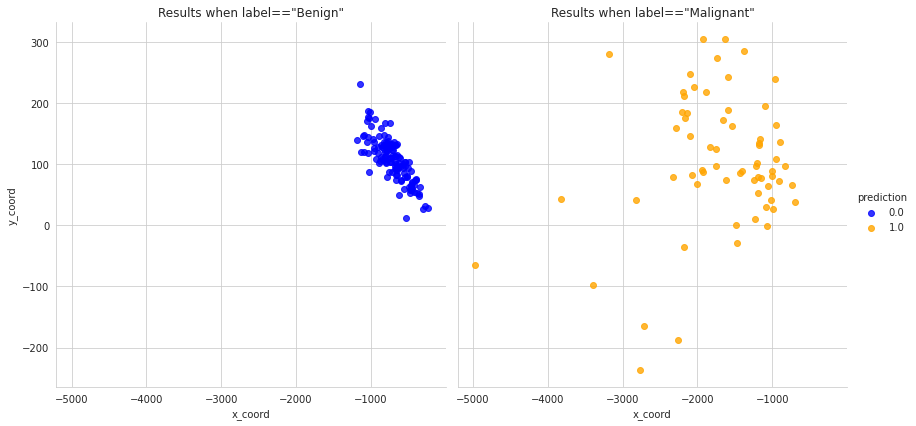

In [ ]:
# TO print the results from logistic regression #
pca_subset = pca_result.select('_c0','features','x_coord','y_coord')
viz_df = pca_subset.join(results,on=['_c0','features']).select('x_coord','y_coord','prediction','label')
viz_df = viz_df.dropna(how='any',subset=['x_coord','y_coord']).toPandas()

a = sns.lmplot(x='x_coord',y='y_coord',hue='prediction',col='label',data=viz_df,
           fit_reg=False,palette={1:'orange',0:'blue'},height=6,aspect=1)
axes = a.axes.flatten()
axes[0].set_title('Results when label=="Benign"')
axes[1].set_title('Results when label=="Malignant"')

Reference Link: https://towardsdatascience.com/logistic-regression-for-malignancy-prediction-in-cancer-27b1a1960184